# Tutorial: optimal binning with binary target

## Basic

To get us started, let's load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the binary target.

In [3]:
variable = "mean radius"
x = df[variable].values
y = data.target

Import and instantiate an ``OptimalBinning`` object class. We pass the variable name, its data type, and a solver, in this case, we choose the constraint programming solver.

In [4]:
from optbinning import OptimalBinning

In [5]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

We fit the optimal binning object with arrays ``x`` and ``y``.

In [6]:
optb.fit(x, y)

OptimalBinning(name='mean radius')

You can check if an optimal solution has been found via the ``status`` attribute:

In [7]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [8]:
optb.splits

array([11.42500019, 12.32999992, 13.09499979, 13.70499992, 15.04500008,
       16.92500019])

#### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``OptimalBinning`` returns an object ``BinningTable`` via the ``binning_table`` attribute.

In [9]:
binning_table = optb.binning_table

In [10]:
type(binning_table)

optbinning.binning.binning_statistics.BinningTable

The `binning_table` is instantiated, but not built. Therefore, the first step is to call the method `build`, which returns a ``pandas.DataFrame``.

In [11]:
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 11.43)",118,0.207381,3,115,0.974576,-3.125170,0.962483,0.087205
1,"[11.43, 12.33)",79,0.138840,3,76,0.962025,-2.710972,0.538763,0.052198
2,"[12.33, 13.09)",68,0.119508,7,61,0.897059,-1.643814,0.226599,0.025513
3,"[13.09, 13.70)",49,0.086116,10,39,0.795918,-0.839827,0.052131,0.006331
4,"[13.70, 15.05)",83,0.145870,28,55,0.662651,-0.153979,0.003385,0.000423
5,"[15.05, 16.93)",54,0.094903,44,10,0.185185,2.002754,0.359566,0.038678
6,"[16.93, inf)",118,0.207381,117,1,0.008475,5.283323,2.900997,0.183436
7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,569,1.000000,212,357,0.627417,,5.043925,0.393784


Let's describe the columns of this binning table:

- Bin: the intervals delimited by the optimal split points.
- Count: the number of records for each bin.
- Count (%): the percentage of records for each bin.
- Non-event: the number of non-event records $(y = 0)$ for each bin.
- Event: the number of event records $(y = 1)$ for each bin.
- Event rate: the percentage of event records for each bin.
- WoE: the Weight-of-Evidence for each bin.
- IV: the Information Value (also known as Jeffrey's divergence) for each bin.
- JS: the Jensen-Shannon divergence for each bin.

The last row shows the total number of records, non-event records, event records, and IV and JS.

You can use the method ``plot`` to visualize the histogram and WoE or event rate curve. Note that the Bin ID corresponds to the binning table index.

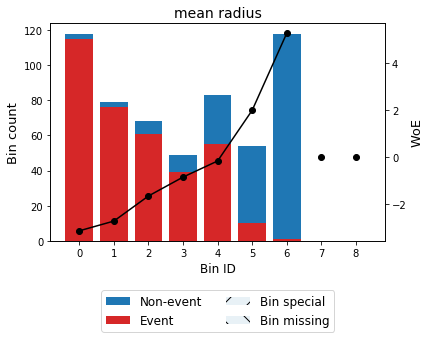

In [12]:
binning_table.plot(metric="woe")

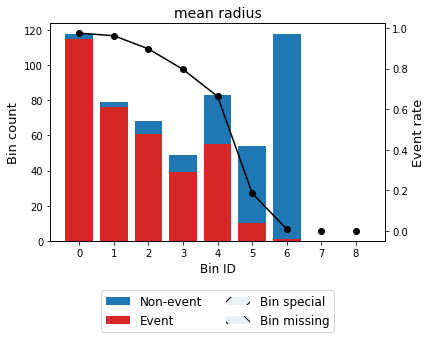

In [13]:
binning_table.plot(metric="event_rate")

Note that WoE is inversely related to the event rate, i.e., a monotonically ascending event rate ensures a monotonically descending WoE and vice-versa. We will see more monotonic trend options in the advanced tutorial.

##### Event rate / WoE transformation

Now that we have checked the binned data, we can transform our original data into WoE or event rate values. You can check the correctness of the transformation using pandas ``value_counts`` method, for instance.

In [14]:
x_transform_woe = optb.transform(x, metric="woe")

In [15]:
pd.Series(x_transform_woe).value_counts()

-3.125170    118
 5.283323    118
-0.153979     83
-2.710972     79
-1.643814     68
 2.002754     54
-0.839827     49
dtype: int64

In [16]:
x_transform_event_rate = optb.transform(x, metric="event_rate")

In [17]:
pd.Series(x_transform_event_rate).value_counts()

0.974576    118
0.008475    118
0.662651     83
0.962025     79
0.897059     68
0.185185     54
0.795918     49
dtype: int64

In [18]:
x_transform_indices = optb.transform(x, metric="indices")

In [19]:
pd.Series(x_transform_indices).value_counts()

0    118
6    118
4     83
1     79
2     68
5     54
3     49
dtype: int64

In [20]:
x_transform_bins = optb.transform(x, metric="bins")

In [21]:
pd.Series(x_transform_bins).value_counts()

[16.93, inf)      118
(-inf, 11.43)     118
[13.70, 15.05)     83
[11.43, 12.33)     79
[12.33, 13.09)     68
[15.05, 16.93)     54
[13.09, 13.70)     49
dtype: int64

#### Categorical variable

Let's load the application_train.csv file from the Kaggle's competition https://www.kaggle.com/c/home-credit-default-risk/data.

In [22]:
df_cat = pd.read_csv("data/kaggle/HomeCreditDefaultRisk/application_train.csv",
                     engine='c')

In [23]:
variable_cat = "NAME_INCOME_TYPE"
x_cat = df_cat[variable_cat].values
y_cat = df_cat.TARGET.values

In [24]:
df_cat[variable_cat].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

We instantiate an ``OptimalBinning`` object class with the variable name, its data type (**categorical**) and a solver, in this case, we choose the mixed-integer programming solver. Also, for this particular example, we set a ``cat_cutoff=0.1`` to create bin others with categories in which the percentage of occurrences is below 10%. This will merge categories State servant, Unemployed, Student, Businessman and Maternity leave.

In [25]:
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="mip",
                      cat_cutoff=0.1)

In [26]:
optb.fit(x_cat, y_cat)

OptimalBinning(cat_cutoff=0.1, dtype='categorical', name='NAME_INCOME_TYPE',
               solver='mip')

In [27]:
optb.status

'OPTIMAL'

The optimal split points are the list of classes belonging to each bin.

In [28]:
optb.splits

[array(['Pensioner'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['State servant', 'Unemployed', 'Student', 'Businessman',
        'Maternity leave'], dtype=object)]

In [29]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Pensioner],55362,0.180033,52380,2982,0.053864,0.433445,0.028249,0.003504
1,[Commercial associate],71617,0.232892,66257,5360,0.074843,0.082092,0.001516,0.000189
2,[Working],158774,0.516320,143550,15224,0.095885,-0.188675,0.019895,0.002483
3,"[State servant, Unemployed, Student, Businessm...",21758,0.070755,20499,1259,0.057864,0.357573,0.007795,0.000969
4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,307511,1.000000,282686,24825,0.080729,,0.057455,0.007146


You can use the method ``plot`` to visualize the histogram and WoE or event rate curve. Note that for categorical variables the optimal bins are **always** monotonically ascending with respect to the event rate. Finally, note that bin 3 corresponds to bin others and is represented by using a lighter color.

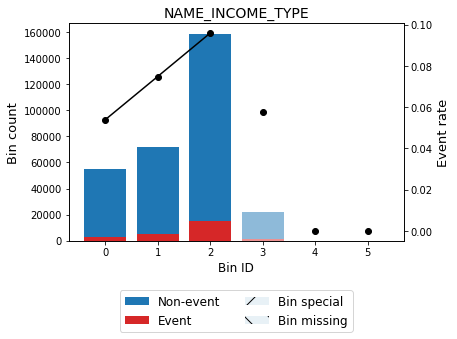

In [30]:
binning_table.plot(metric="event_rate")

Same as for the numerical dtype, we can transform our original data into WoE or event rate values. Transformation of data including categories not present during training return zero WoE or event rate.

In [31]:
x_new = ["Businessman", "Working", "Unknown"]

In [32]:
x_transform_woe = optb.transform(x_new, metric="woe")

In [33]:
pd.DataFrame({variable_cat: x_new, "WoE": x_transform_woe})

,NAME_INCOME_TYPE,WoE
0,Businessman,0.357573
1,Working,-0.188675
2,Unknown,0.000000


## Advanced

#### Optimal binning Information

The ``OptimalBinning`` can print overview information about the options settings, problem statistics, and the solution of the computation. By default, ``print_level=1``.

In [34]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="mip")
optb.fit(x, y)

OptimalBinning(name='mean radius', solver='mip')

If ``print_level=0``, a minimal output including the header, variable name, status, and total time are printed.

In [35]:
optb.information(print_level=0)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean radius                     
  Status  : OPTIMAL                         

  Time    : 0.0487  sec



If ``print_level>=1``, statistics on the pre-binning phase and the solver are printed. More detailed timing statistics are also included.

In [36]:
optb.information(print_level=1)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean radius                     
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                     9
    Number of refinements                  1

  Solver statistics
    Type                                 mip
    Number of variables                   85
    Number of constraints                 45
    Objective value                   5.0439
    Best objective bound              5.0439

  Timing
    Total time                          0.05 sec
    Pre-processing                      0.00 sec   (  1.44%)
    Pre-binning                         0.00 sec   (  8.05%)
    Solver                              0.04 sec   ( 88.80%)
    Post-processing                     0.00 sec   (  0.39%)



If ``print_level=2``, the list of all options of the ``OptimalBinning`` are displayed. The output contains the option name, its current value and an indicator for how it was set. The unchanged options from the default settings are noted by "d", and the options set by the user changed from the default settings are noted by "U". This is inspired by the NAG solver e04mtc printed output, see https://www.nag.co.uk/numeric/cl/nagdoc_cl26/html/e04/e04mtc.html#fcomments.

In [37]:
optb.information(print_level=2)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                         mean radius   * U
    dtype                          numerical   * d
    prebinning_method                   cart   * d
    solver                               mip   * U
    divergence                            iv   * d
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    min_bin_n_nonevent                    no   * d
    max_bin_n_nonevent                    no   * d
    min_bin_n_event                       no   * d
    max_bin_n_event                       no   * d
    monotonic_trend                     auto   * d
    min_event_rate_diff                    0   * d
    max_pvalue     

#### Binning table statistical analysis

The ``analysis`` method performs a statistical analysis of the binning table, computing the statistics Gini index, Information Value (IV), Jensen-Shannon divergence, and the quality score. Additionally, several statistical significance tests between consecutive bins of the contingency table are performed: a frequentist test using the Chi-square test or the Fisher's exact test, and a Bayesian A/B test using the beta distribution as a conjugate prior of the Bernoulli distribution.

In [38]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.12175489
    IV (Jeffrey)             0.05745546
    JS (Jensen-Shannon)      0.00714565
    Hellinger                0.00716372
    Triangular               0.02843984
    KS                       0.08364544
    HHI                      0.35824301
    HHI (normalized)         0.22989161
    Cramer's V               0.06007763
    Quality score            0.18240827

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1   223.890188 1.281939e-50 4.799305e-71       1.0
        1      2   268.591060 2.301360e-60 6.289833e-76       1.0



In [39]:
binning_table.analysis(pvalue_test="fisher")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.12175489
    IV (Jeffrey)             0.05745546
    JS (Jensen-Shannon)      0.00714565
    Hellinger                0.00716372
    Triangular               0.02843984
    KS                       0.08364544
    HHI                      0.35824301
    HHI (normalized)         0.22989161
    Cramer's V               0.06007763
    Quality score            0.18240827

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  odd ratio      p-value     P[A > B]  P[B > A]
        0      1   1.420990 2.091361e-51 4.799305e-71       1.0
        1      2   1.310969 4.434577e-62 6.289833e-76       1.0



#### Event rate / WoE monotonicity

The ``monotonic_trend`` option permits forcing a monotonic trend to the event rate curve. The default setting "auto" should be the preferred option, however, some business constraints might require to impose different trends. The default setting "auto" chooses the monotonic trend most likely to maximize the information value from the options "ascending", "descending", "peak" and "valley" using a machine-learning-based classifier.

In [40]:
variable = "mean texture"
x = df[variable].values
y = data.target

In [41]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(x, y)

OptimalBinning(name='mean texture')

In [42]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 15.05)",92,0.161687,4,88,0.956522,-2.569893,0.584986,0.057939
1,"[15.05, 16.39)",61,0.107206,8,53,0.868852,-1.369701,0.151658,0.017602
2,"[16.39, 17.03)",29,0.050967,6,23,0.793103,-0.822585,0.029715,0.003613
3,"[17.03, 18.46)",79,0.138840,17,62,0.784810,-0.772772,0.072239,0.008812
4,"[18.46, 19.47)",55,0.096661,20,35,0.636364,-0.038466,0.000142,0.000018
5,"[19.47, 20.20)",36,0.063269,18,18,0.500000,0.521150,0.017972,0.002221
6,"[20.20, 21.71)",72,0.126538,43,29,0.402778,0.915054,0.111268,0.013443
7,"[21.71, 22.74)",40,0.070299,27,13,0.325000,1.252037,0.113865,0.013371
8,"[22.74, 24.00)",29,0.050967,24,5,0.172414,2.089765,0.207309,0.022035
9,"[24.00, 26.98)",43,0.075571,30,13,0.302326,1.357398,0.142656,0.016578


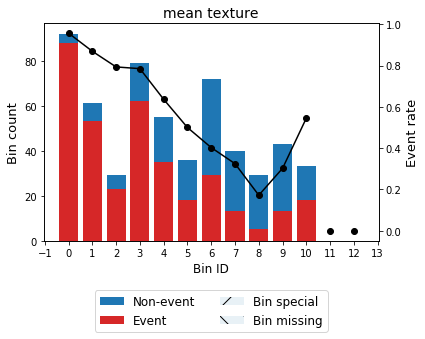

In [43]:
binning_table.plot(metric="event_rate")

For example, we can force the variable mean texture to be monotonically descending with respect to the probability of having breast cancer.

In [44]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp",
                      monotonic_trend="descending")
optb.fit(x, y)

OptimalBinning(monotonic_trend='descending', name='mean texture')

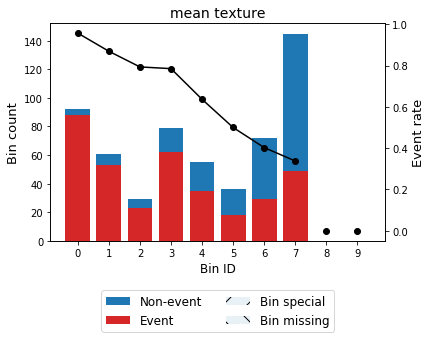

In [45]:
binning_table = optb.binning_table
binning_table.build()
binning_table.plot(metric="event_rate")

#### Reduction of dominating bins

Version 0.3.0 introduced a new constraint to produce more homogeneous solutions by reducing a concentration metric such as the difference between the largest and smallest bin. The added regularization parameter ``gamma`` controls the importance the reduction term. Larger values specify stronger regularization. Continuing with the previous example

In [46]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp",
                      monotonic_trend="descending", gamma=0.5)
optb.fit(x, y)

OptimalBinning(gamma=0.5, monotonic_trend='descending', name='mean texture')

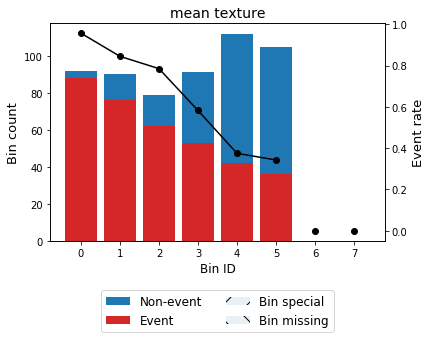

In [47]:
binning_table = optb.binning_table
binning_table.build()
binning_table.plot(metric="event_rate")

Note that the new solution produces more homogeneous bins, removing the dominance of bin 7 previously observed.

#### User-defined split points

In some situations, we have defined split points or bins required to satisfy a priori belief,  knowledge or business constraint. The ``OptimalBinning`` permits to pass user-defined split points for numerical variables and user-defined bins for categorical variables. The supplied information is used as a pre-binning, disallowing any pre-binning method set by the user. Furthermore, version 0.5.0 introduces ``user_splits_fixed`` parameter, to allow the user to fix some user-defined splits, so these must appear in the solution.

Example numerical variable:

In [48]:
user_splits =       [  14,    15,    16,    17,    20,    21,    22,    27]
user_splits_fixed = [False, True,  True, False, False, False, False, False]

In [49]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="mip",
                      user_splits=user_splits, user_splits_fixed=user_splits_fixed)

optb.fit(x, y)

OptimalBinning(name='mean texture', solver='mip',
               user_splits=[14, 15, 16, 17, 20, 21, 22, 27],
               user_splits_fixed=array([False,  True,  True, False, False, False, False, False]))

In [50]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 14.00)",54,0.094903,2,52,0.962963,-2.736947,0.372839,0.035974
1,"[14.00, 15.00)",37,0.065026,2,35,0.945946,-2.341051,0.207429,0.021268
2,"[15.00, 16.00)",43,0.075571,7,36,0.837209,-1.116459,0.075720,0.009002
3,"[16.00, 20.00)",210,0.369069,59,151,0.719048,-0.418593,0.060557,0.007515
4,"[20.00, 21.00)",45,0.079086,26,19,0.422222,0.834807,0.057952,0.007041
5,"[21.00, 22.00)",49,0.086116,30,19,0.387755,0.977908,0.086338,0.010382
6,"[22.00, 27.00)",99,0.173989,71,28,0.282828,1.451625,0.372304,0.042839
7,"[27.00, inf)",32,0.056239,15,17,0.531250,0.395986,0.009161,0.001138
8,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000


In [51]:
optb.information()

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean texture                    
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                     9
    Number of refinements                  0

  Solver statistics
    Type                                 mip
    Number of variables                  137
    Number of constraints                 55
    Objective value                   1.2423
    Best objective bound              1.2423

  Timing
    Total time                          0.08 sec
    Pre-processing                      0.00 sec   (  3.03%)
    Pre-binning                         0.00 sec   (  1.38%)
    Solver                              0.08 sec   ( 94.83%)
    Post-processing                     0.00 sec   (  0.12%)



Example categorical variable:

In [52]:
user_splits = np.array([
               ['Businessman'], 
               ['Working'],
               ['Commercial associate'],
               ['Pensioner', 'Maternity leave'],
               ['State servant'],
               ['Unemployed', 'Student']], dtype=object)

In [53]:
optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="cp",
                      user_splits=user_splits,
                      user_splits_fixed=[False, True, True, True, True, True])

optb.fit(x_cat, y_cat)

OptimalBinning(dtype='categorical', name='NAME_INCOME_TYPE',
               user_splits=array([list(['Working']), list(['Commercial associate']),
       list(['Pensioner', 'Maternity leave']), list(['State servant']),
       list(['Unemployed', 'Student'])], dtype=object),
               user_splits_fixed=array([ True,  True,  True,  True,  True]))

In [54]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Businessman, Pensioner, Maternity leave]",55377,0.180081,52393,2984,0.053885,0.433023,0.028206,0.003499
1,[State servant],21703,0.070576,20454,1249,0.057550,0.363350,0.008010,0.000996
2,[Commercial associate],71617,0.232892,66257,5360,0.074843,0.082092,0.001516,0.000189
3,[Working],158774,0.516320,143550,15224,0.095885,-0.188675,0.019895,0.002483
4,"[Unemployed, Student]",40,0.000130,32,8,0.200000,-1.046191,0.000219,0.000026
5,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,307511,1.000000,282686,24825,0.080729,,0.057846,0.007193


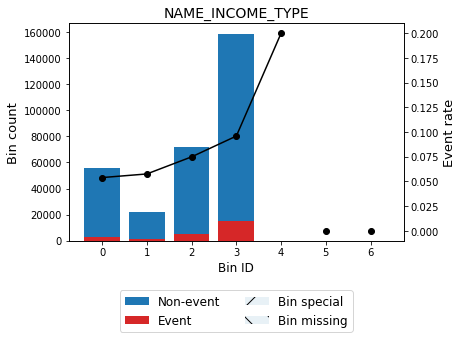

In [55]:
optb.binning_table.plot(metric="event_rate")

In [56]:
optb.information()

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Name    : NAME_INCOME_TYPE                
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                     5
    Number of refinements                  1

  Solver statistics
    Type                                  cp
    Number of booleans                     0
    Number of branches                     0
    Number of conflicts                    0
    Objective value                    57843
    Best objective bound               57843

  Timing
    Total time                          0.29 sec
    Pre-processing                      0.04 sec   ( 13.35%)
    Pre-binning                         0.24 sec   ( 82.78%)
    Solver                              0.01 sec   (  3.65%)
      model generation                  0.01 sec   ( 91.73%)
      optimizer                         0.00 sec   (  8.27%)
    Post-processing                     0

#### Performance: choosing a solver

For small problems, say less than ``max_n_prebins<=20``, the ``solver="mip"`` tends to be faster than ``solver="cp"``. However, for medium and large problems, experiments show the contrary. For very large problems, we recommend the use of the commercial solver LocalSolver via ``solver="ls"``. See the specific LocalSolver tutorial.

#### Missing data and special codes

For this example, let's load data from the FICO Explainable Machine Learning Challenge: https://community.fico.com/s/explainable-machine-learning-challenge

In [57]:
df = pd.read_csv("data/FICO_challenge/heloc_dataset_v1.csv", sep=",")

The data dictionary of this challenge includes three special values/codes:

* -9 No Bureau Record or No Investigation
* -8 No Usable/Valid Trades or Inquiries
* -7 Condition not Met (e.g. No Inquiries, No Delinquencies) 

In [58]:
special_codes = [-9, -8, -7]

In [59]:
variable = "AverageMInFile"
x = df[variable].values
y = df.RiskPerformance.values

In [60]:
df.RiskPerformance.unique()

array(['Bad', 'Good'], dtype=object)

Target is a categorical dichotomic variable, which can be easily transform into numerical.

In [61]:
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

For the sake of completeness, we include a few missing values

In [62]:
idx = np.random.randint(0, len(x), 500)
x = x.astype(float)
x[idx] = np.nan

In [63]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="mip",
                      special_codes=special_codes)

optb.fit(x, y)

OptimalBinning(name='AverageMInFile', solver='mip', special_codes=[-9, -8, -7])

In [64]:
optb.information(print_level=1)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Name    : AverageMInFile                  
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                    14
    Number of refinements                  0

  Solver statistics
    Type                                 mip
    Number of variables                  203
    Number of constraints                105
    Objective value                   0.3248
    Best objective bound              0.3248

  Timing
    Total time                          0.13 sec
    Pre-processing                      0.00 sec   (  1.66%)
    Pre-binning                         0.01 sec   (  7.29%)
    Solver                              0.12 sec   ( 90.37%)
    Post-processing                     0.00 sec   (  0.16%)



In [65]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 30.50)",547,0.052299,96,451,0.824497,-1.459291,0.092542,0.010640
1,"[30.50, 48.50)",1053,0.100679,294,759,0.720798,-0.860594,0.069051,0.008375
2,"[48.50, 54.50)",537,0.051343,191,346,0.644320,-0.506338,0.012750,0.001577
3,"[54.50, 60.50)",596,0.056984,237,359,0.602349,-0.327435,0.006013,0.000748
4,"[60.50, 65.50)",627,0.059948,276,351,0.559809,-0.152558,0.001388,0.000173
5,"[65.50, 70.50)",656,0.062721,303,353,0.538110,-0.064908,0.000264,0.000033
6,"[70.50, 75.50)",671,0.064155,329,342,0.509687,0.049075,0.000155,0.000019
7,"[75.50, 81.50)",766,0.073238,401,365,0.476501,0.181892,0.002426,0.000303
8,"[81.50, 101.50)",2007,0.191892,1154,853,0.425012,0.390058,0.029077,0.003612
9,"[101.50, 116.50)",866,0.082800,533,333,0.384527,0.558207,0.025454,0.003141


Note the dashed bins 10 and 11, corresponding to the special codes bin and the missing bin, respectively.

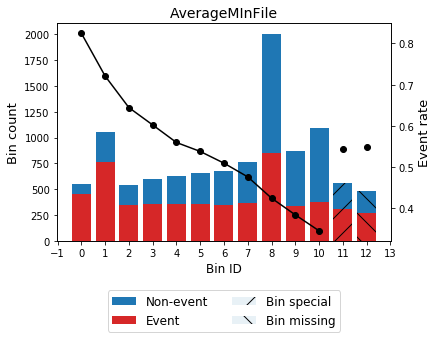

In [66]:
binning_table.plot(metric="event_rate")

#### Treat special codes separately

Version 0.13.0 introduced the option to pass a dictionary of special codes to treat them separately. This feature provides more flexibility to the modeller. Note that a special code can be a single value or a list of values, for example, a combination of several special values.

In [67]:
special_codes = {'special_1': -9, "special_2": -8, "special_3": -7}

x[10:20] = -8
x[100:105] = -7

optb = OptimalBinning(name=variable, dtype="numerical", solver="mip",
                      special_codes=special_codes)

optb.fit(x, y)

OptimalBinning(name='AverageMInFile', solver='mip',
               special_codes={'special_1': -9, 'special_2': -8,
                              'special_3': -7})

In [68]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 30.50)",546,0.052204,96,450,0.824176,-1.457072,0.092135,0.010595
1,"[30.50, 48.50)",1052,0.100583,294,758,0.720532,-0.859276,0.068788,0.008343
2,"[48.50, 54.50)",537,0.051343,191,346,0.644320,-0.506338,0.012750,0.001577
3,"[54.50, 60.50)",595,0.056889,237,358,0.601681,-0.324645,0.005902,0.000735
4,"[60.50, 65.50)",627,0.059948,276,351,0.559809,-0.152558,0.001388,0.000173
5,"[65.50, 70.50)",653,0.062434,303,350,0.535988,-0.056373,0.000198,0.000025
6,"[70.50, 75.50)",671,0.064155,329,342,0.509687,0.049075,0.000155,0.000019
7,"[75.50, 81.50)",764,0.073047,401,363,0.475131,0.187386,0.002568,0.000321
8,"[81.50, 101.50)",2003,0.191510,1152,851,0.424863,0.390670,0.029109,0.003616
9,"[101.50, 116.50)",866,0.082800,533,333,0.384527,0.558207,0.025454,0.003141


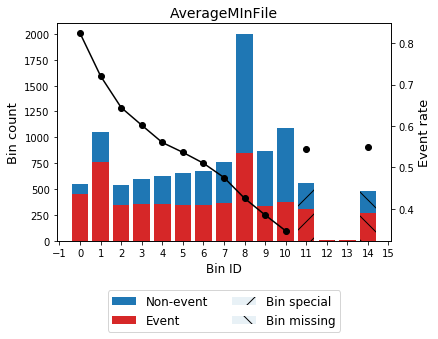

In [69]:
optb.binning_table.plot(metric="event_rate")

In [70]:
special_codes = {'special_1': -9, "special_comb": [-7, -8]}

optb = OptimalBinning(name=variable, dtype="numerical", solver="mip",
                      special_codes=special_codes)

optb.fit(x, y)

OptimalBinning(name='AverageMInFile', solver='mip',
               special_codes={'special_1': -9, 'special_comb': [-7, -8]})

In [71]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 30.50)",546,0.052204,96,450,0.824176,-1.457072,0.092135,0.010595
1,"[30.50, 48.50)",1052,0.100583,294,758,0.720532,-0.859276,0.068788,0.008343
2,"[48.50, 54.50)",537,0.051343,191,346,0.644320,-0.506338,0.012750,0.001577
3,"[54.50, 60.50)",595,0.056889,237,358,0.601681,-0.324645,0.005902,0.000735
4,"[60.50, 65.50)",627,0.059948,276,351,0.559809,-0.152558,0.001388,0.000173
5,"[65.50, 70.50)",653,0.062434,303,350,0.535988,-0.056373,0.000198,0.000025
6,"[70.50, 75.50)",671,0.064155,329,342,0.509687,0.049075,0.000155,0.000019
7,"[75.50, 81.50)",764,0.073047,401,363,0.475131,0.187386,0.002568,0.000321
8,"[81.50, 101.50)",2003,0.191510,1152,851,0.424863,0.390670,0.029109,0.003616
9,"[101.50, 116.50)",866,0.082800,533,333,0.384527,0.558207,0.025454,0.003141


#### Verbosity option

For debugging purposes, we can print information on each step of the computation by triggering the ``verbose`` option.

In [72]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="mip", verbose=True)
optb.fit(x, y)

2021-10-23 19:24:52,398 | INFO : Optimal binning started.
2021-10-23 19:24:52,400 | INFO : Options: check parameters.
2021-10-23 19:24:52,406 | INFO : Pre-processing started.
2021-10-23 19:24:52,409 | INFO : Pre-processing: number of samples: 10459
2021-10-23 19:24:52,411 | INFO : Pre-processing: number of clean samples: 9976
2021-10-23 19:24:52,411 | INFO : Pre-processing: number of missing samples: 483
2021-10-23 19:24:52,412 | INFO : Pre-processing: number of special samples: 0
2021-10-23 19:24:52,413 | INFO : Pre-processing terminated. Time: 0.0012s
2021-10-23 19:24:52,413 | INFO : Pre-binning started.
2021-10-23 19:24:52,425 | INFO : Pre-binning: number of prebins: 15
2021-10-23 19:24:52,426 | INFO : Pre-binning: number of refinements: 0
2021-10-23 19:24:52,428 | INFO : Pre-binning terminated. Time: 0.0107s
2021-10-23 19:24:52,429 | INFO : Optimizer started.
2021-10-23 19:24:52,432 | INFO : Optimizer: classifier predicts descending monotonic trend.
2021-10-23 19:24:52,435 | INFO :

OptimalBinning(name='AverageMInFile', solver='mip', verbose=True)